<a href="https://colab.research.google.com/github/lambroz/BriscolaAI/blob/main/BriscolaAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

[Briscola](https://en.wikipedia.org/wiki/Briscola) is probably the most common Italian card game. Although the game is pretty simple, it involves thinking ahead and remembering previous cards. In this notebook, a TensorFlow DQN agent is trained to learn this game.

# Set-up

Install the necessary library to run also on Google Colab with GPU.

In [ ]:
!sudo apt-get install -y xvfb ffmpeg x11-utils
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -U tensorboard_plugin_profile
!pip install wandb

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents pyvirtualdisplay gym[atari]
except Exception:
    pass

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.
ERROR: gym 0.18.0 has requirement pyglet<=1.5.0,>=1.4.0, but you'll have pyglet 1.3.2 which is incompatible.
Requirement already up-to-date: tensorboard_plugin_profile in /usr/local/lib/python3.7/dist-packages (2.4.0)
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
import time
import logging
import wandb

import tensorflow as tf
from tensorflow import keras

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver, dynamic_episode_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment, py_environment, parallel_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy, policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory, time_step
from tf_agents.trajectories.time_step import restart, termination, transition
from tf_agents.trajectories import policy_step
from tf_agents.utils import common
from tf_agents.eval.metric_utils import log_metrics
from tf_agents.specs import tensor_spec, BoundedArraySpec
from tf_agents.networks import sequential, q_network

from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict

from google.colab import drive

import pyvirtualdisplay
import IPython
import PIL.ImageDraw
import PIL.Image
from PIL import ImageFont
from IPython.display import Image, clear_output

In [ ]:
device_name = tf.test.gpu_device_name()
if not device_name:
  print('GPU device not found!')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found!


Uncomment the next line to monitor GPU usage:

In [ ]:
#wandb.init()

Setup `pyvirtualdisplay`.



In [ ]:
vdisplay = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Mount Google Drive to load pictures of cards and save trained models.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create the game

In the next cells, the elements of the game have been created. With respect to the traditional game, here the game ends when one of the two players reaches more than 61 points.

In [ ]:
class Card:

  def __init__(self, suit=None, value=None):
    self.suit = suit
    self.value = value

  def suit_to_int(self):
    """
    Arbitrary encoding of the suits to int.
    """
    if self.suit == 'Denari':
      return 1
    elif self.suit == 'Coppe':
      return 2
    elif self.suit == 'Spade':
      return 3
    elif self.suit == 'Bastoni':
      return 4
    elif self.suit is None:
      return 0
    else:
      raise Exception('Suit not recognized!')

  def is_carico(self): #"Carico" is 1 or a 3
    if self.value == 1 or self.value == 3:
      return True
    else:
      return False

  def show(self):
    print(self.value, 'of', self.suit)

In [ ]:
class Deck:

  def __init__(self):
    self.cards = []
    self.build()

  def build(self):
    for s in ['Denari', 'Coppe', 'Spade', 'Bastoni']:
      for v in range(1, 11):
        self.cards.append(Card(s,v))

  def show(self):
    for c in self.cards:
      c.show()

  def shuffle(self):
    random.shuffle(self.cards) 

  def draw(self):
    return self.cards.pop()

In [ ]:
class Player:

  def __init__(self, name, train_env=None):
    self.name = name
    self.train_env = train_env 
    self.hand = []
    self.score = 0
    self.reward = 0
    self.observations = {}
    self.briscola = Card()

  def draw(self, deck):
    self.hand.append(deck.draw())

  def draw_briscola(self, briscola):
    self.hand.append(briscola)

  def set_briscola(self, card):
    self.briscola = card

  def is_briscola(self, card):
    if card.suit == self.briscola.suit:
      return True
    else:
      return False

  def show_hand(self):
    for c in self.hand:
      c.show()

In [ ]:
class RandomPlayer(Player):

    def __init__(self, name):
      super().__init__(name)

    def play(self, observations=None, card_currently_on_the_table=None):
      random.shuffle(self.hand)
      return self.hand.pop() #Just play a random card

In [ ]:
class SimplePlayer(Player):

  def __init__(self, name):
    super().__init__(name)

  def play(self, observation=None, card_currently_on_the_table=None):
    if observation[0]: #Check if this player is playing first
      for card in self.hand: #If first, avoid playing briscola or carico
        if card.is_carico():
          continue
        elif self.is_briscola(card):
          continue
        else:
          self.hand.remove(card)
          return card
    else: #Second
      if self.is_briscola(card_currently_on_the_table): #Avoid playing briscola or carico when the opponent plays briscola
          for card in self.hand:
            if card.is_carico():
              continue
            elif self.is_briscola(card):
              continue
            else:
              self.hand.remove(card)
              return card
      else: #If the opponent has not played a briscola 
          for card in self.hand: #If you have it, try play a carico
            if card.is_carico() and card.suit == card_currently_on_the_table.suit and card_currently_on_the_table.value != 1:
              self.hand.remove(card)
              return card
          if card_currently_on_the_table.is_carico(): #If the opponent has played a carico, try to catch it with a briscola
            for card in self.hand:
              if self.is_briscola(card):
                self.hand.remove(card)
                return card
    random.shuffle(self.hand)
    return self.hand.pop() #Otherwise, play a random card

In [ ]:
class BriscolaEnv(py_environment.PyEnvironment):

  STATES = ['first',
            'last_draw',
            'briscola_value', 'card0_value', 'card1_value', 'card2_value', 'card_prev_played_by_me_value', 'card_prev_played_by_opp_value', 'card_currently_on_the_table', 
            'briscola_suit_is_none', 'briscola_suit_is_denari', 'briscola_suit_is_coppe', 'briscola_suit_is_spade', 'briscola_suit_is_bastoni',
            'card0_suit_is_none', 'card0_suit_is_denari', 'card0_suit_is_coppe', 'card0_suit_is_spade', 'card0_suit_is_bastoni',
            'card1_suit_is_none', 'card1_suit_is_denari', 'card1_suit_is_coppe', 'card1_suit_is_spade', 'card1_suit_is_bastoni',
            'card2_suit_is_none', 'card2_suit_is_denari', 'card2_suit_is_coppe', 'card2_suit_is_spade', 'card2_suit_is_bastoni',
            'card_prev_played_by_me_suit_is_none', 'card_prev_played_by_me_suit_is_denari', 'card_prev_played_by_me_suit_is_coppe', 'card_prev_played_by_me__suitis_spade', 'card_prev_played_by_me_suit_is_bastoni',
            'card_prev_played_by_opp_suit_is_none', 'card_prev_played_by_opp_suit_is_denari', 'card_prev_played_by_opp_suit_is_coppe', 'card_prev_played_by_opp_suit_is_spade', 'card_prev_played_by_opp_suit_is_bastoni',
            'card_currently_on_the_table_suit_is_none', 'card_currently_on_the_table_suit_is_denari', 'card_currently_on_the_table_suit_is_coppe', 'card_currently_on_the_table_suit_is_spade', 'card_currently_on_the_table_suit_is_bastoni']

  ACTION_ELEMENTS = 3

  def __init__(self, discount=1.0, render_game=False, save_images=False):
    super().__init__()
    self._action_spec = BoundedArraySpec(shape=(), dtype=np.int32, name="action", minimum=0, maximum=2)
    self._observation_spec = BoundedArraySpec(shape=(len(BriscolaEnv.STATES),), dtype=np.float32, name="observation", minimum=0, maximum=1)
    self._episode_ended = False
    self.discount = discount
    self.render_game = render_game
    self.save_images = save_images
    self.setup_score_system()
    self.player1 = Player('Player1')
    #self.player2 = RandomPlayer('Player2')
    self.player2 = SimplePlayer('Player2')

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def setup_score_system(self):
    self.card_score = defaultdict(lambda : 0)
    self.card_score[1] = 11
    self.card_score[3] = 10
    self.card_score[8] = 2
    self.card_score[9] = 3
    self.card_score[10] = 4

  def strogest_card(self, card1, card2):
    if card1 == 1: #Ace is the strongest card
      return 1
    elif card2 == 1:
      return 2
    elif card1 == 3: #3 is the strongest card
      return 1
    elif card2 == 3:
      return 2
    elif card1 > card2: #For the other cards, normal ranking
      return 1
    else: 
      return 2

  def evaluate(self, card_player1, card_player2, first_to_play):
    """
    This function evaluates a briscola hand. 
    It returns a tuple with the player who won it (1 or 2) and the score.
    """
    hand_score = self.card_score[card_player1.value] + self.card_score[card_player2.value]
    if card_player1.suit == card_player2.suit: #In the case of both players playing the same suit
      return self.strogest_card(card_player1.value, card_player2.value), hand_score
    elif card_player1.suit == self.briscola.suit: #In case there is a briscola, the briscola always wins
      return 1, hand_score
    elif card_player2.suit == self.briscola.suit:
      return 2, hand_score
    else: #In case no briscola and different suits, the player who started first wins
      return first_to_play, hand_score
    
  def assign_cards(self, hand_winner):
    if len(self.deck.cards) > 1: #There are still cards in the deck
      self.player1.draw(self.deck)
      self.player2.draw(self.deck)
    elif len(self.deck.cards) == 1: #Need to assign the briscola
      if hand_winner == 1:
        self.player1.draw(self.deck)
        self.player2.draw_briscola(self.briscola)
      else:
        self.player2.draw(self.deck)
        self.player1.draw_briscola(self.briscola)
    else: #For the last two hands, there are no more cards in the deck
      pass

  def _step(self, action, verbose=False):

    ###First, check if episode has ended
    if self._episode_ended:
      return self.reset()

    ###Choose the card according to the action and remove it from the hand
    if action > len(self.player1.hand) - 1: #If the agent wants to play the third card with only two cards in hand
      action = random.randint(0, len(self.player1.hand) - 1)
    self.card_player1 = self.player1.hand[action]  
    del self.player1.hand[action]

    ###Render the game
    if self.render_game:
        self.render()

    ###Observe the game status and play
    last_draw = len(self.deck.cards) == 1
    if self.first_player == 1: 
      card_currently_on_the_table = self.card_player1
      observations_player2 = self.observe_game(self.player2, last_draw, self.card_previously_played_by_player2, self.card_previously_played_by_player1, self.card_player1)
      self.card_player2 = self.player2.play(observations_player2, self.card_currently_on_the_table)
      if self.render_game:
        self.render()

    ###Verbose
    if verbose:
      print("---------")
      print("First to play", self.first_player)
    
    ###Evaluate scores
    self.first_player, hand_score = self.evaluate(self.card_player1, self.card_player2, self.first_player) #Evaluate the outcome of the hand. Important: self.first_player becomes the hand_winner!!
    
    ###Verbose
    if verbose:
      print("Current score:", self.get_scores())
      print("Briscola:")
      self.briscola.show()
      print("Player 1 played:")
      self.card_player1.show()
      print("Player 2 played:")
      self.card_player2.show()
      print("Winner:", self.first_player) #First to play is not the winner
      print("Score:", hand_score)
    
    ###Assign the score to the winner of the hand and who will go first in the next hand
    self.card_previously_played_by_player1 = self.card_player1
    self.card_previously_played_by_player2 = self.card_player2
    if self.first_player == 1: 
      self.player1.score += hand_score
      self.player1.reward = hand_score #Reward policy based on the hand score
      self.player2.reward = -hand_score
    else:
      self.player2.score += hand_score
      self.player1.reward = -hand_score
      self.player2.reward = hand_score
    self.assign_cards(self.first_player)

    ###Check if game is over
    normalisation = 140
    if self.player1.score > 60:
     self._episode_ended = True
     if self.render_game:
        self.render()
     observations_player1 = self.observe_game(self.player1, last_draw, self.card_previously_played_by_player1, self.card_previously_played_by_player2, self.card_currently_on_the_table)
     return termination(observations_player1, (self.player1.reward + 20) / normalisation) #20 extra points for winning the game. The reward is normalised
    if self.player2.score > 60:
     self._episode_ended = True
     if self.render_game:
        self.render()
     observations_player1 = self.observe_game(self.player1, last_draw, self.card_previously_played_by_player1, self.card_previously_played_by_player2, self.card_currently_on_the_table)
     return termination(observations_player1, (self.player1.reward - 20) / normalisation) #-20 points for loosing the game. The reward is normalised
    if self.player1.score + self.player2.score == 120: #Tie
      self._episode_ended = True
      if self.render_game:
        self.render()
      observations_player1 = self.observe_game(self.player1, last_draw, self.card_previously_played_by_player1, self.card_previously_played_by_player2, self.card_currently_on_the_table)
      return termination(observations_player1, self.player1.reward / normalisation)

    ###Start the next round 
    last_draw = len(self.deck.cards) == 1
    self.card_currently_on_the_table = Card()
    self.card_player1 = Card()
    self.card_player2 = Card()
    if self.render_game:
        self.render()
    if self.first_player == 1: 
      pass 
    else:
      observations_player2 = self.observe_game(self.player2, last_draw, self.card_previously_played_by_player2, self.card_previously_played_by_player1, self.card_currently_on_the_table)
      self.card_player2 = self.player2.play(observations_player2, self.card_currently_on_the_table)
      if self.render_game:
        self.render()
      self.card_currently_on_the_table = self.card_player2
    observations_player1 = self.observe_game(self.player1, last_draw, self.card_previously_played_by_player1, self.card_previously_played_by_player2, self.card_currently_on_the_table)
    return transition(observations_player1, self.player1.reward / normalisation, self.discount)

  def _reset(self):
    self.setup_first_hand()
    if self.render_game:
      self.render()
    last_draw = False
    if self.first_player == 1: #Agent (player 1) plays first
      observations_player1 = self.observe_game(self.player1, last_draw, self.card_previously_played_by_player1, self.card_previously_played_by_player2, self.card_currently_on_the_table)
    else: #Agent plays second
      observations_player2 = self.observe_game(self.player2, last_draw, self.card_previously_played_by_player2, self.card_previously_played_by_player1, self.card_currently_on_the_table)
      self.card_player2 = self.player2.play(observations_player2, self.card_currently_on_the_table) 
      if self.render_game:
        self.render()
      observations_player1 = self.observe_game(self.player1, last_draw, self.card_previously_played_by_player1, self.card_previously_played_by_player2, self.card_player2)
    return restart(np.array(observations_player1, dtype=np.float32))

  def setup_first_hand(self):
    self._episode_ended = False
    self.last_draw = False
    self.first_player = random.randint(1,2)
    self.deck = Deck()
    self.card_player1 = Card() #Card currently played by player1
    self.card_player2 = Card()
    self.card_previously_played_by_player1 = Card() #Card previously played by player1
    self.card_previously_played_by_player2 = Card()
    self.card_currently_on_the_table = Card()
    self.player1.score = 0
    self.player2.score = 0
    self.deck.shuffle()
    self.player1.hand = []
    self.player2.hand = []
    for i in range(3):
      self.player1.draw(self.deck)
      self.player2.draw(self.deck)
    self.deck.shuffle()
    self.briscola = self.deck.draw()
    self.player1.set_briscola(self.briscola)
    self.player2.set_briscola(self.briscola)

  def observe_game(self, player, last_draw, card_previously_played_by_me, card_previously_played_by_my_opponent, card_currently_on_the_table):
    self.last_draw = last_draw
    self.card_previously_played_by_me = card_previously_played_by_me
    self.card_previously_played_by_my_opponent = card_previously_played_by_my_opponent
    self.card_currently_on_the_table = card_currently_on_the_table
    if card_currently_on_the_table.value is None or card_currently_on_the_table.value == 0: #The first_to_play perspective changes between player1 and player2
      first_to_play = True
    else:
      first_to_play = False
    return self.create_observations_list(player, first_to_play) 

  def one_hot_encode_suits(self):
    """
    Create one hot encoding for suits and missing card.
    """
    suits_encoder = LabelBinarizer()
    codes = [0, 1, 2, 3, 4]
    suits_encoder.fit(codes) 
    suits_variables = set()
    for key in self.observations:
      if 'suit' in key: 
        suits_variables.add(key)
    for key in suits_variables:
      transformed = suits_encoder.transform([self.observations[key]])
      for code in codes:
          self.observations[key + ' ' + str(code)] = transformed[0][code]
      del self.observations[key]

  def encode_values(self, value):
    """
    Encode (arbitrarily) card values from 0 to 1 according to how much they are worthy.
    """
    if value is None:
      return 0
    elif value == 1:
      return 1.
    elif value == 3:
      return 0.909 #10/11
    elif value == 10:
      return 0.364 #4/11
    elif value == 9:
      return 0.272 #3/11
    elif value == 8:
      return 0.181 #2/11
    else: 
      return value * 0.012 #1/11/7

  def create_observations_list(self, player, first_to_play, do_encode_values=True, do_one_hot_encode_suits=True, verbose=False):
    """
    Function that creates an observations list, which will be passed to the agents in order to make decision.
    Missing values are encoded as 0.
    """
    try:
      card0_value = player.hand[0].value
      card0_suit = player.hand[0].suit_to_int()
    except IndexError:
      card0_value = 0
      card0_suit = 0
    try:
      card1_value = player.hand[1].value
      card1_suit = player.hand[1].suit_to_int()
    except IndexError:
      card1_value = 0
      card1_suit = 0
    try:
      card2_value = player.hand[2].value
      card2_suit = player.hand[2].suit_to_int()
    except IndexError:
      card2_value = 0
      card2_suit = 0
    self.observations = { 
                         'First' : int(first_to_play), #1 first to play, 0 second
                         'Last draw' : int(self.last_draw), #Hand when the briscola is assigned
                         'Briscola value' : self.briscola.value, #Range: [1,10] -> Then encoded between [0,1]
                         'Briscola suit' : self.briscola.suit_to_int(), #Range: [1:4]
                         'Card0 value' : card0_value, #Range: [1,10] + 0 for missing, same below for values -> Then encoded between [0,1]
                         'Card0 suit' : card0_suit, ##Range: [1,4] + None for missing, same below for suits, suits will be one-hot-encoded        
                         'Card1 value' : card1_value, 
                         'Card1 suit' : card1_suit, 
                         'Card2 value' : card2_value, 
                         'Card2 suit' : card2_suit, 
                         'Card prev played by me value' : self.card_previously_played_by_me.value, 
                         'Card prev played by me suit' : self.card_previously_played_by_me.suit_to_int(), 
                         'Card prev played by my opp value' : self.card_previously_played_by_my_opponent.value, 
                         'Card prev played by my opp suit' : self.card_previously_played_by_my_opponent.suit_to_int(), 
                         'Card currently on the table value' : self.card_currently_on_the_table.value, 
                         'Card currently on the table suit' : self.card_currently_on_the_table.suit_to_int(), 
    }
    if verbose:
      print(self.observations)
    if do_encode_values:
      for key, val in self.observations.items():
        if 'value' in key:
           self.observations[key] = self.encode_values(val)
    if do_one_hot_encode_suits:
      self.one_hot_encode_suits()
    return  np.array([v for k,v in self.observations.items()], dtype=np.float32) #Convert dictionary in a list

  def get_scores(self):
    return (self.player1.score, self.player2.score)

  def render(self, mode='human', frame_speed=2):
    screen_width = 600
    screen_height = 400

    img = PIL.Image.new('RGB', (600, 400), color=(255,255,255))
    d = PIL.ImageDraw.Draw(img)
    font = ImageFont.load_default()
    _, height = d.textsize("W", font)

    ###Resize factor
    resize_factor = 12

    ###Player1' cards
    offset = 0
    for card in self.player1.hand:
      img_card = PIL.Image.open('drive/MyDrive/briscola_cards/' + str(card.value) + str(card.suit) + '.jpg', 'r')
      b, h = img_card.size
      img_card = img_card.resize((b // resize_factor,  h // resize_factor))
      img.paste(img_card, (200+offset, screen_height - h // resize_factor))
      offset += b // resize_factor

    ###Player2' cards
    offset = 0
    for card in self.player2.hand:
      img_card = PIL.Image.open('drive/MyDrive/briscola_cards/Yellow_back.jpg', 'r')
      b, h = img_card.size
      img_card = img_card.resize((b // resize_factor,  h // resize_factor))
      img.paste(img_card, (300+offset, 0))
      offset += b // resize_factor
    
    ###Briscola
    if len(self.deck.cards) > 0:
      img_card = PIL.Image.open('drive/MyDrive/briscola_cards/' + str(self.briscola.value) + str(self.briscola.suit) + '.jpg', 'r')
      b, h = img_card.size
      img_card = img_card.resize((b // resize_factor,  h // resize_factor))
      img_card = img_card.rotate(90, expand=True)
      img.paste(img_card, (20, screen_height // 2))
      img_card = PIL.Image.open('drive/MyDrive/briscola_cards/Yellow_back.jpg', 'r')
      b, h = img_card.size
      img_card = img_card.resize((b // resize_factor,  h // resize_factor))
      img.paste(img_card, (0, screen_height // 2 - h // resize_factor // 4))

    if self.card_player1.value is not None:
      img_card = PIL.Image.open('drive/MyDrive/briscola_cards/' + str(self.card_player1.value) + str(self.card_player1.suit) + '.jpg', 'r')
      b, h = img_card.size
      img_card = img_card.resize((b // resize_factor,  h // resize_factor))
      img.paste(img_card, (200 + b // resize_factor, screen_height - h // resize_factor * 2 - 20))

    if self.card_player2.value is not None:
      img_card = PIL.Image.open('drive/MyDrive/briscola_cards/' + str(self.card_player2.value) + str(self.card_player2.suit) + '.jpg', 'r')
      b, h = img_card.size
      img_card = img_card.resize((b // resize_factor,  h // resize_factor))
      img.paste(img_card, (300 + b // resize_factor, h // resize_factor + 20))

    ###Display scores and info
    d.text((0, screen_height - h // resize_factor // 2), f"Player1 score: {self.player1.score}", fill=(0, 0, 255))
    d.text((0, h // resize_factor // 2), f"Player2 score: {self.player2.score}", fill=(255, 0, 0))
    if self.first_player == 1:
      first = 1
    else:
      first = 2
    d.text((0, screen_height // 2 - 50), f"First to play: Player{first}", fill=(0, 0, 0))
    if self.last_draw:
      d.text((0, screen_height // 2 + 80), f"One card in the deck left", fill=(0, 0, 0))

    ###Display winner and loser
    if self.player1.score > 60:
      d.text((0, screen_height - h // resize_factor // 2 + height), f"WINNER", fill=(0, 0, 255))
      d.text((0, h // resize_factor // 2 + height), f"LOSER", fill=(255, 0, 0))
    elif self.player2.score > 60:
      d.text((0, screen_height - h // resize_factor // 2 + height), f"LOSER", fill=(0, 0, 255))
      d.text((0, h // resize_factor // 2 + height), f"WINNER", fill=(255, 0, 0))
    elif self.player1.score == 60 and self.player2.score == 60:
      d.text((0, screen_height - h // resize_factor // 2 + height), f"TIE", fill=(0, 0, 255))
      d.text((0, h // resize_factor // 2 + height), f"TIE", fill=(255, 0, 0))

    ###Display complete image
    display(img) 

    ###Save image to make gif
    if self.save_images:
      img.save("gif/frame" + str(time.time()) + ".png", "PNG")

    time.sleep(frame_speed)
    clear_output(wait=True)    

# Random player vs simple player

In this section, two types of player are compared. The first one playes randomly by always choosing the middle card in his hand. Instead, the second type of player plays according to a simple scripted strategy similar to the one below:

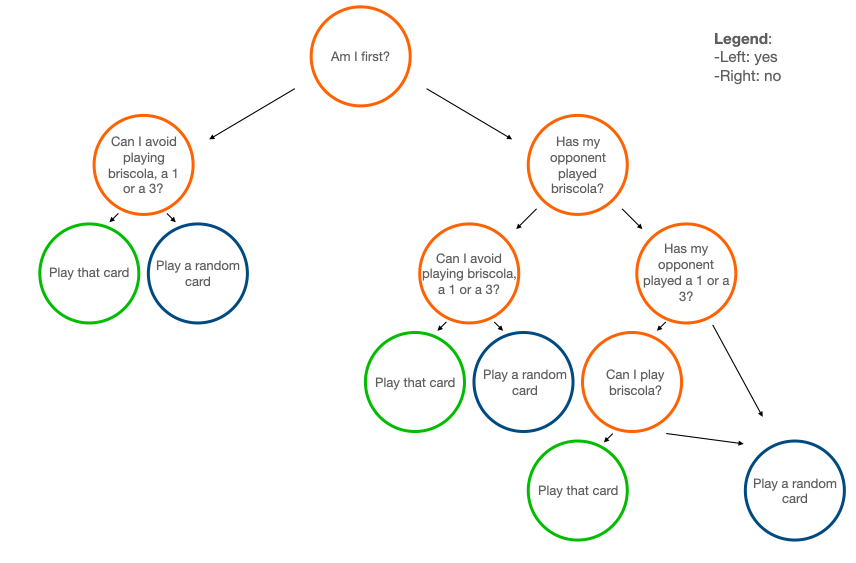

Below a single game is simulated:

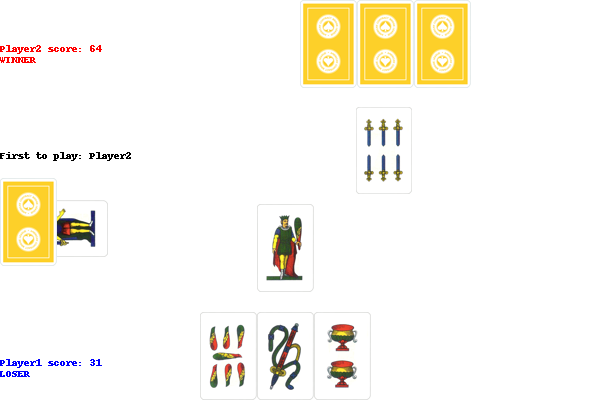

In [ ]:
random.seed(1)
env = BriscolaEnv(render_game=True)

time_step = env.reset() 
while not time_step.is_last():
  time_step = env.step(1) #Always play card in the middle

env.close()

In [ ]:
def plot_scores(scores, player1_name='Player 1', player1_colour='r', player2_name='Player 2', player2_colour='b'):
    number_of_games = len(scores)
    games = [n for n in range(number_of_games)]
    plt.figure(figsize=(10, 6))
    plt.plot(games, scores[:,0], '.', color = player1_colour, label = player1_name + ' (Victory rate: ' + str(np.sum(scores[:,0] > 60) * 100 / number_of_games) + '%)')
    plt.plot(games, scores[:,1], '.', color = player2_colour, label = player2_name + ' (Victory rate: ' + str(np.sum(scores[:,1] > 60) * 100 / number_of_games) + '%)')
    plt.xlim((0, number_of_games))
    plt.ylim((0, 100))
    plt.xlabel('Games')
    plt.ylabel('Score')
    plt.legend()
    plt.hlines(60, 0, number_of_games, linestyles='--', linewidth=2, colors='gray')

Show the score of 2000 games.

CPU times: user 2min 2s, sys: 59.4 ms, total: 2min 2s
Wall time: 2min 3s


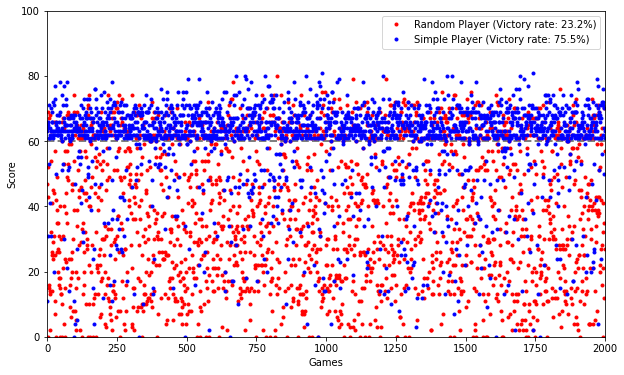

In [ ]:
%%time
random.seed(2)
env = BriscolaEnv()

number_of_games = 2000
scores = np.zeros((number_of_games, 2))
for n in range(number_of_games):
  done = False
  time_step = env.reset() 
  while not time_step.is_last():
    time_step = env.step(1) #Always play card in the middle
    
  scores[n] = env.get_scores()

plot_scores(scores, player1_name = 'Random Player', player2_name = 'Simple Player')

# Create and train a DQN agent

A DQN agent with 3 output (i.e. play left/centre/right card) has been trained using 44 features defined in `BriscolaEnv`. Card values have been scaled between 0 and 1, while suits have been one-hot-encoded.



In [ ]:
train_py_env = BriscolaEnv()
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec())

In [ ]:
agent = dqn_agent.DqnAgent(train_env.time_step_spec(),
                           train_env.action_spec(),
                           q_network=q_net,
                           optimizer = keras.optimizers.Adam())

agent.initialize()

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=500000)

In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [ ]:
train_metrics = [
        tf_metrics.NumberOfEpisodes(),
        tf_metrics.EnvironmentSteps(),
        tf_metrics.AverageReturnMetric(),
        tf_metrics.AverageEpisodeLengthMetric(),
    ]
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

collect_driver = dynamic_step_driver.DynamicStepDriver(train_env, 
                                                       agent.collect_policy,
                                                       observers=[replay_buffer.add_batch] + train_metrics,
                                                       num_steps=2) #Collect N steps for each training iteration

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [ ]:
%%time
initial_collect_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
initial_driver = dynamic_step_driver.DynamicStepDriver(train_env, initial_collect_policy, observers=[replay_buffer.add_batch], num_steps=50000)
final_time_step, final_policy_state = initial_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


CPU times: user 6min 33s, sys: 2.05 s, total: 6min 36s
Wall time: 6min 37s


In [ ]:
collect_driver.run = common.function(collect_driver.run)
agent.train = common.function(agent.train)

In [ ]:
def train_agent(n_iterations, saved_model_name=False):
    """
    Function to train an agent.
    """
    t1 = time.time()
    t_i = time.time()
    time_step = None
    if saved_model_name:
      saved_policy = tf.compat.v2.saved_model.load(saved_model_name)
      policy_state = saved_policy.get_initial_state(train_env.batch_size)
    else:
      policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        if iteration % 10000 == 0:
          print("Iteration: ", iteration, "deltat:", round(time.time() - t_i, 1))
          t_i = time.time()
          log_metrics(train_metrics)

    dt = round(time.time() - t1, 1)
    print(f"Training time: {dt}s")

In [ ]:
train_agent(300000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 1
		 EnvironmentSteps = 2
		 AverageReturn = -0.19285714626312256
		 AverageEpisodeLength = 1.0


Iteration:  0 deltat: 2.1


INFO:absl: 
		 NumberOfEpisodes = 1207
		 EnvironmentSteps = 20002
		 AverageReturn = -0.15142858028411865
		 AverageEpisodeLength = 18.399999618530273


Iteration:  10000 deltat: 135.1


INFO:absl: 
		 NumberOfEpisodes = 2363
		 EnvironmentSteps = 40002
		 AverageReturn = 0.05500000715255737
		 AverageEpisodeLength = 17.700000762939453


Iteration:  20000 deltat: 135.1


INFO:absl: 
		 NumberOfEpisodes = 3527
		 EnvironmentSteps = 60002
		 AverageReturn = -0.034999996423721313
		 AverageEpisodeLength = 17.100000381469727


Iteration:  30000 deltat: 133.4


INFO:absl: 
		 NumberOfEpisodes = 4685
		 EnvironmentSteps = 80002
		 AverageReturn = -0.04928571730852127
		 AverageEpisodeLength = 17.799999237060547


Iteration:  40000 deltat: 133.6


INFO:absl: 
		 NumberOfEpisodes = 5840
		 EnvironmentSteps = 100002
		 AverageReturn = 0.16785714030265808
		 AverageEpisodeLength = 17.5


Iteration:  50000 deltat: 133.8


INFO:absl: 
		 NumberOfEpisodes = 6987
		 EnvironmentSteps = 120002
		 AverageReturn = 0.15571428835391998
		 AverageEpisodeLength = 17.399999618530273


Iteration:  60000 deltat: 133.6


INFO:absl: 
		 NumberOfEpisodes = 8155
		 EnvironmentSteps = 140002
		 AverageReturn = -0.1785714328289032
		 AverageEpisodeLength = 18.700000762939453


Iteration:  70000 deltat: 134.9


INFO:absl: 
		 NumberOfEpisodes = 9307
		 EnvironmentSteps = 160002
		 AverageReturn = 0.22928571701049805
		 AverageEpisodeLength = 16.399999618530273


Iteration:  80000 deltat: 132.8


INFO:absl: 
		 NumberOfEpisodes = 10463
		 EnvironmentSteps = 180002
		 AverageReturn = 0.23571428656578064
		 AverageEpisodeLength = 17.299999237060547


Iteration:  90000 deltat: 134.6


INFO:absl: 
		 NumberOfEpisodes = 11623
		 EnvironmentSteps = 200002
		 AverageReturn = 0.21285715699195862
		 AverageEpisodeLength = 18.0


Iteration:  100000 deltat: 135.0


INFO:absl: 
		 NumberOfEpisodes = 12784
		 EnvironmentSteps = 220002
		 AverageReturn = 0.19571428000926971
		 AverageEpisodeLength = 17.399999618530273


Iteration:  110000 deltat: 138.6


INFO:absl: 
		 NumberOfEpisodes = 13944
		 EnvironmentSteps = 240002
		 AverageReturn = 0.07285713404417038
		 AverageEpisodeLength = 17.0


Iteration:  120000 deltat: 140.2


INFO:absl: 
		 NumberOfEpisodes = 15103
		 EnvironmentSteps = 260002
		 AverageReturn = -0.030000001192092896
		 AverageEpisodeLength = 16.5


Iteration:  130000 deltat: 135.8


INFO:absl: 
		 NumberOfEpisodes = 16262
		 EnvironmentSteps = 280002
		 AverageReturn = 0.12785716354846954
		 AverageEpisodeLength = 17.700000762939453


Iteration:  140000 deltat: 136.5


INFO:absl: 
		 NumberOfEpisodes = 17410
		 EnvironmentSteps = 300002
		 AverageReturn = 0.19857141375541687
		 AverageEpisodeLength = 18.100000381469727


Iteration:  150000 deltat: 136.5


INFO:absl: 
		 NumberOfEpisodes = 18561
		 EnvironmentSteps = 320002
		 AverageReturn = 0.06642856448888779
		 AverageEpisodeLength = 17.0


Iteration:  160000 deltat: 135.6


INFO:absl: 
		 NumberOfEpisodes = 19715
		 EnvironmentSteps = 340002
		 AverageReturn = 0.012857133522629738
		 AverageEpisodeLength = 16.200000762939453


Iteration:  170000 deltat: 135.3


INFO:absl: 
		 NumberOfEpisodes = 20864
		 EnvironmentSteps = 360002
		 AverageReturn = 0.08642858266830444
		 AverageEpisodeLength = 17.700000762939453


Iteration:  180000 deltat: 135.1


INFO:absl: 
		 NumberOfEpisodes = 22017
		 EnvironmentSteps = 380002
		 AverageReturn = 0.047142863273620605
		 AverageEpisodeLength = 16.899999618530273


Iteration:  190000 deltat: 137.3


INFO:absl: 
		 NumberOfEpisodes = 23170
		 EnvironmentSteps = 400002
		 AverageReturn = 0.09214286506175995
		 AverageEpisodeLength = 17.700000762939453


Iteration:  200000 deltat: 137.4


INFO:absl: 
		 NumberOfEpisodes = 24324
		 EnvironmentSteps = 420002
		 AverageReturn = 0.2021428644657135
		 AverageEpisodeLength = 16.5


Iteration:  210000 deltat: 139.0


INFO:absl: 
		 NumberOfEpisodes = 25473
		 EnvironmentSteps = 440002
		 AverageReturn = -0.02142857387661934
		 AverageEpisodeLength = 17.700000762939453


Iteration:  220000 deltat: 135.6


INFO:absl: 
		 NumberOfEpisodes = 26625
		 EnvironmentSteps = 460002
		 AverageReturn = 0.13357143104076385
		 AverageEpisodeLength = 16.899999618530273


Iteration:  230000 deltat: 135.4


INFO:absl: 
		 NumberOfEpisodes = 27781
		 EnvironmentSteps = 480002
		 AverageReturn = 0.2864285707473755
		 AverageEpisodeLength = 15.300000190734863


Iteration:  240000 deltat: 137.7


INFO:absl: 
		 NumberOfEpisodes = 28934
		 EnvironmentSteps = 500002
		 AverageReturn = 0.041428569704294205
		 AverageEpisodeLength = 18.600000381469727


Iteration:  250000 deltat: 137.5


INFO:absl: 
		 NumberOfEpisodes = 30077
		 EnvironmentSteps = 520002
		 AverageReturn = 0.31142857670783997
		 AverageEpisodeLength = 16.899999618530273


Iteration:  260000 deltat: 133.6


INFO:absl: 
		 NumberOfEpisodes = 31239
		 EnvironmentSteps = 540002
		 AverageReturn = 0.09642858058214188
		 AverageEpisodeLength = 16.399999618530273


Iteration:  270000 deltat: 130.5


INFO:absl: 
		 NumberOfEpisodes = 32402
		 EnvironmentSteps = 560002
		 AverageReturn = 0.005714285187423229
		 AverageEpisodeLength = 18.399999618530273


Iteration:  280000 deltat: 133.2


INFO:absl: 
		 NumberOfEpisodes = 33554
		 EnvironmentSteps = 580002
		 AverageReturn = 0.23071427643299103
		 AverageEpisodeLength = 17.399999618530273


Iteration:  290000 deltat: 131.6
Training time: 4059.9s


In [ ]:
saver = policy_saver.PolicySaver(agent.policy)
saver.save('drive/MyDrive/policy_300k')

INFO:tensorflow:Assets written to: drive/MyDrive/policy_300k/assets


INFO:tensorflow:Assets written to: drive/MyDrive/policy_300k/assets


# Test the agent

In this section, the DQN agent is evaluated against the simple player.

In [ ]:
#policy = tf.saved_model.load('drive/MyDrive/policy_300k') #Uncomment if you have already trained an agent

In [ ]:
eval_py_env = BriscolaEnv()
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env) 

metric_utils.eager_compute(train_metrics, eval_env, agent.policy, 2000) #Num eval episodes 

OrderedDict([('NumberOfEpisodes',
              <tf.Tensor: shape=(), dtype=int64, numpy=2000>),
             ('EnvironmentSteps',
              <tf.Tensor: shape=(), dtype=int64, numpy=34582>),
             ('AverageReturn',
              <tf.Tensor: shape=(), dtype=float32, numpy=0.29000002>),
             ('AverageEpisodeLength',
              <tf.Tensor: shape=(), dtype=float32, numpy=17.4>)])

CPU times: user 5min 21s, sys: 577 ms, total: 5min 22s
Wall time: 5min 22s


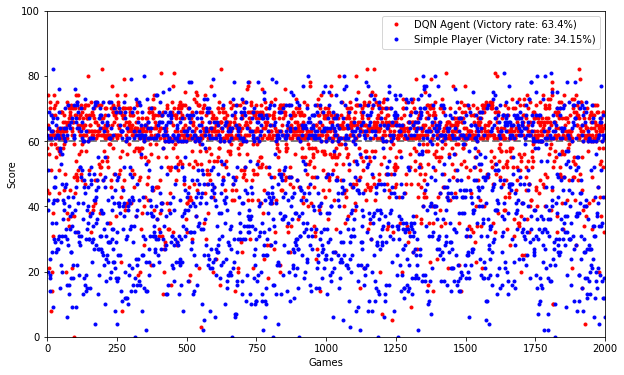

In [ ]:
%%time
random.seed(3)
number_of_games = 2000
scores_agent = np.zeros((number_of_games, 2))
for n in range(number_of_games):
  done = False
  time_step = eval_env.reset() 
  while not time_step.is_last():
    action_step = agent.policy.action(time_step)
    time_step = eval_env.step(action_step.action)
    
  scores_agent[n] = eval_py_env.get_scores()

plot_scores(scores_agent, player1_name = 'DQN Agent', player2_name = 'Simple Player')

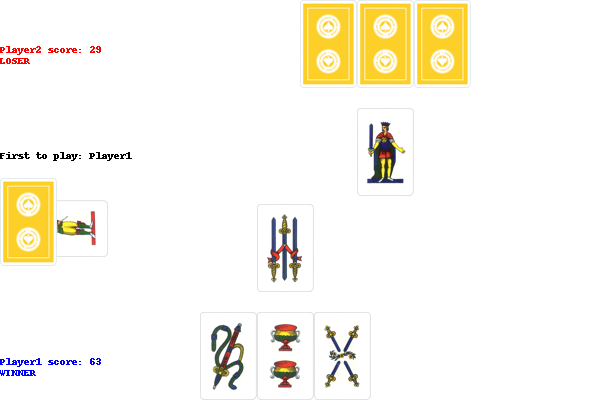

In [ ]:
random.seed(7)
env_py_test = BriscolaEnv(render_game=True, save_images=True)
env_test = tf_py_environment.TFPyEnvironment(env_py_test)

time_step = env_test.reset() 
while not time_step.is_last():
  action_step = agent.policy.action(time_step)
  #action_step = policy.action(time_step) #Uncomment the next line if you have already trained an agent
  time_step = env_test.step(action_step)

env_test.close()

The next line will make a gif of the game.

In [ ]:
if os.path.isdir('gif'):
  img, *imgs = [PIL.Image.open(f) for f in sorted(glob.glob('gif/*.png'))]
  img.save(fp='gif/game.gif', format='GIF', append_images=imgs, save_all=True, duration=2000, loop=0)
else:
  os.mkdir('gif')